In [208]:
import copy
import os
import math
import sys

import numpy as np
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.append('../')
from slow_reservoir.model import RNN
from slow_reservoir.dataset.dynamic_state import State

import matplotlib.pyplot as plt

%matplotlib inline

In [209]:
sigma_sq = 0.5

In [210]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=2):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals


def make_sample_signal(g=2):
    input_signals = np.zeros([200, 2, 100])
    phi = np.linspace(-2, 2, 100)
    
    for i, signal_mu in enumerate(np.linspace(-1, 1, 200)):
        signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
        for t in range(2):
            input_signals[i, t] = np.random.poisson(signal_base)
        
    return input_signals

In [245]:
# config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_all_slow/20220526_all_slow.cfg'
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_4/20220526_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
        n_in=cfg['DATALOADER']['INPUT_NEURON'],
        n_out=1,
        n_hid=cfg['MODEL']['SIZE'],
        n_reservoir=cfg['MODEL']['RESERVOIR'],
        device=device,
        alpha_fast=cfg['MODEL']['ALPHA_FAST'],
        alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
        sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    ).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [246]:
mu_p = 0.3
sigma_p = 0.3
sigma_l = math.sqrt(1/1.25) * 0.5

g = 1 / (4 * (sigma_l**2))
# g = 1 / (4 * sigma_l)
input_signal = make_signal_for_prior(
    time_length=50, 
    mu_p=mu_p,
    sigma_p=sigma_p,
    uncertainty=0.5,
    g=g,
)
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device) 
hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
    
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()
    
initial_state = copy.deepcopy(neural_dynamics[0, -1])
initial_res_state = copy.deepcopy(reservoir_dynamics[0, -1])

input_signal = make_sample_signal(g=g)
hidden_np = initial_state
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   
reservoir_np = initial_res_state
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
    
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device)                                                      
    
_, output_list, _, _ = model(inputs, hidden, reservoir, 2)

mu_l_list = np.linspace(-1, 1, 200)
bayesian_optimal = mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + \
    mu_l_list * (sigma_p**2/(sigma_p**2+sigma_l**2))



In [247]:
input_signal.shape

(200, 2, 100)

In [248]:
g

1.25

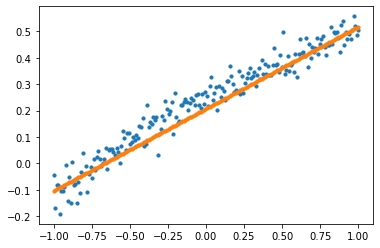

In [249]:
plt.scatter(
    np.linspace(-1, 1, 200), 
    output_list[:, 0, 0].detach().numpy(),
    s=10,
)
plt.scatter(
    np.linspace(-1, 1, 200), 
    bayesian_optimal,
    s=10,
)

In [244]:
abs_loss = np.sum(abs(output_list[:, 0, 0].detach().numpy() - bayesian_optimal))
bo_sum = np.sum(abs(bayesian_optimal))
print(f'{100*abs_loss / bo_sum:.2f}%')

43.48%


## main-networkをランダムにした場合

In [69]:
mu_p = 0.5
sigma_p = 0.8
sigma_l = math.sqrt(1/1.25) * 0.5

g = 1 / (4 * (sigma_l**2))
input_signal = make_signal_for_prior(
    time_length=50, 
    mu_p=mu_p,
    sigma_p=sigma_p,
    uncertainty=0.5,
    g=g,
)
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device) 
hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
    
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()
    
# initial_state = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
initial_state = np.zeros((1, cfg['MODEL']['SIZE']))
initial_res_state = copy.deepcopy(reservoir_dynamics[0, -1])

input_signal = make_sample_signal(g=g)
hidden_np = initial_state
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   
reservoir_np = initial_res_state
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
    
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device)                                                      
    
_, output_list, _, _ = model(inputs, hidden, reservoir, 2)

mu_l_list = np.linspace(-1, 1, 200)
bayesian_optimal = mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + \
    mu_l_list * (sigma_p**2/(sigma_p**2+sigma_l**2))



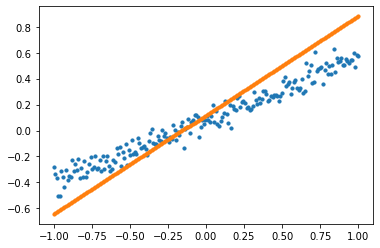

In [70]:
plt.scatter(
    np.linspace(-1, 1, 200), 
    output_list[:, 0, 0].detach().numpy(),
    s=10,
)
plt.scatter(
    np.linspace(-1, 1, 200), 
    bayesian_optimal,
    s=10,
)

In [71]:
abs_loss = np.sum(abs(output_list[:, 0, 0].detach().numpy() - bayesian_optimal))
bo_sum = np.sum(abs(bayesian_optimal))
print(f'{100*abs_loss / bo_sum:.2f}%')

38.01%


## Sub-networkをランダムにした場合

In [72]:
mu_p = 0.5
sigma_p = 0.8
sigma_l = math.sqrt(1/1.25) * 0.5

g = 1 / (4 * (sigma_l**2))
input_signal = make_signal_for_prior(
    time_length=50, 
    mu_p=mu_p,
    sigma_p=sigma_p,
    uncertainty=0.5,
    g=g,
)
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device) 
hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
    
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()
    
initial_state = copy.deepcopy(neural_dynamics[0, -1])
# initial_res_state = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
initial_res_state = np.zeros((1, cfg['MODEL']['RESERVOIR']))

input_signal = make_sample_signal(g=g)

hidden_np = initial_state
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device)                                                   
reservoir_np = initial_res_state
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
    
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device)                                                      
    
_, output_list, _, _ = model(inputs, hidden, reservoir, 1)

mu_l_list = np.linspace(-1, 1, 200)
bayesian_optimal = mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + \
    mu_l_list * (sigma_p**2/(sigma_p**2+sigma_l**2))



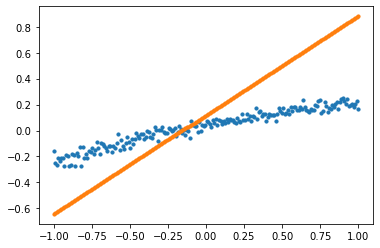

In [73]:
plt.scatter(
    np.linspace(-1, 1, 200), 
    output_list[:, 0, 0].detach().numpy(),
    s=10,
)
plt.scatter(
    np.linspace(-1, 1, 200), 
    bayesian_optimal,
    s=10,
)

In [74]:
abs_loss = np.sum(abs(output_list[:, 0, 0].detach().numpy() - bayesian_optimal))
bo_sum = np.sum(abs(bayesian_optimal))
print(f'{100*abs_loss / bo_sum:.2f}%')

70.53%


In [16]:
np.linspace(0, 0.5, 6)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [17]:
np.linspace(-0.5, 0.5, 11)

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])